# Librerias

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import StandardScaler , OrdinalEncoder, LabelEncoder

# Funciones

# Importar Bases de Datos

In [4]:
VERBOSE = False
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

In [5]:
calendario = pd.read_csv(os.path.join(DATA_PATH, "daily_calendar_with_events.csv"))
precios = pd.read_csv(os.path.join(DATA_PATH, "item_prices.csv"))
ventas = pd.read_csv(os.path.join(DATA_PATH, "item_sales.csv"))

# Preproccesing

## Tabla Ventas Modificada

In [6]:
# Imprimir las dimensiones del DataFrame original
print("Dimensiones DF original: ", ventas.shape)

# Encontrar el último día (última columna del DataFrame)
ultimodia = int(str(ventas.columns.to_list()[-1]).split("_")[1])

# Crear una lista con los siguientes 28 días
lista = [ultimodia + x for x in range(1, 29)]

# Añadir columnas para cada día adicional con ventas 0
for i in lista:
    colname = "d_" + str(i)
    ventas[colname] = 0

# Imprimir las dimensiones del DataFrame original con las columnas adicionales
print("Dimensiones DF con 28 dias adicionales: ", ventas.shape)

# Inicializar lista para guardar los encoders
idlist = []

# Codificar las variables categóricas
LE = LabelEncoder()
iditem = LE.fit(ventas["item"])
idlist.append({l: i for (i, l) in enumerate(iditem.classes_)})
idcat = LE.fit(ventas["category"])
idlist.append({l: i for (i, l) in enumerate(idcat.classes_)})
iddep = LE.fit(ventas["department"])
idlist.append({l: i for (i, l) in enumerate(iddep.classes_)})
idsto = LE.fit(ventas["store"])
idlist.append({l: i for (i, l) in enumerate(idsto.classes_)})
idstocode = LE.fit(ventas["store_code"])
idlist.append({l: i for (i, l) in enumerate(idstocode.classes_)})
idreg = LE.fit(ventas["region"])
idlist.append({l: i for (i, l) in enumerate(idreg.classes_)})

# Reemplazar valores categóricos por sus códigos
for i in zip(ventas.columns[1:7].tolist(), idlist):
    ventas[i[0]] = ventas[i[0]].replace(i[1]).astype(int)

# Transformar la base de datos, días por fila
ventasmelt = ventas.melt(id_vars=ventas.columns[:7], value_vars=ventas.columns[7:], var_name="d", value_name="Cantidad")

# Verificar nulos
if len(ventasmelt.isnull().sum()[ventasmelt.isnull().sum() > 0]) == 0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", ventasmelt.isnull().sum()[ventasmelt.isnull().sum() > 0])

# Verificar filas duplicadas, eliminarlas y resetear el índice
print("Numero de filas duplicadas: ", len(ventasmelt[ventasmelt.duplicated(keep=False)]))
ventasmelt.drop_duplicates(inplace=True)
ventasmelt.reset_index(drop=True, inplace=True)

# Imprimir estadísticas básicas
print("Suma de ventas totales: ", ventasmelt["Cantidad"].sum())
print("Observaciones con ventas 0: ", len(ventasmelt[ventasmelt["Cantidad"] == 0].index))

# Imprimir el número de valores únicos para cada columna, excepto "Cantidad" y "d"
for i in ventasmelt:
    if i != "Cantidad" and i != "d":
        print(f"Numero de {i} unicos: ", ventasmelt[i].nunique())

# Imprimir las dimensiones del DataFrame tratado
print("Dimensiones DF tratado: ", ventasmelt.shape)



Dimensiones DF original:  (30490, 1920)
Dimensiones DF con 28 dias adicionales:  (30490, 1948)
Sin nulos
Numero de filas duplicadas:  0
Suma de ventas totales:  65695409
Observaciones con ventas 0:  40630814
Numero de id unicos:  30490
Numero de item unicos:  3049
Numero de category unicos:  3
Numero de department unicos:  7
Numero de store unicos:  10
Numero de store_code unicos:  10
Numero de region unicos:  3
Dimensiones DF tratado:  (59181090, 9)


In [7]:
ventas=ventasmelt.copy()

In [8]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 9 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          object
 1   item        int32 
 2   category    int32 
 3   department  int32 
 4   store       int32 
 5   store_code  int32 
 6   region      int32 
 7   d           object
 8   Cantidad    int64 
dtypes: int32(6), int64(1), object(2)
memory usage: 2.6+ GB


In [9]:
ventas.head()

,id,item,category,department,store,store_code,region,d,Cantidad
0,ACCESORIES_1_001_NYC_1,0,0,0,2,3,1,d_1,0
1,ACCESORIES_1_002_NYC_1,1,0,0,2,3,1,d_1,0
2,ACCESORIES_1_003_NYC_1,2,0,0,2,3,1,d_1,0
3,ACCESORIES_1_004_NYC_1,3,0,0,2,3,1,d_1,0
4,ACCESORIES_1_005_NYC_1,4,0,0,2,3,1,d_1,0


## Tabla Calendario Modificada

In [10]:
calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [11]:
calendario["date"]=pd.to_datetime(calendario["date"]) # formato fecha en columna date

In [12]:
calendario.sort_values(["date"], ascending = True, inplace = True)

In [13]:
# Imprimir dimensiones del DataFrame original
print("Dimensiones DF original: ", calendario.shape)

# Agregar los últimos 28 días a proyectar
date_offset = pd.DateOffset(days=1)
ultimafila = calendario.iloc[-1:]

for dia in lista:
    new_row = ultimafila.copy()
    new_row['d'] = "d_" + str(dia)
    new_row['date'] = ultimafila["date"] + date_offset
    new_row['weekday'] = new_row['date'].dt.day_name()
    new_row['weekday_int'] = np.nan
    new_row['event'] = np.nan
    ultimafila = new_row.copy()
    calendario = pd.concat([calendario, new_row], ignore_index=True)

# Verificar nulos
if len(calendario.isnull().sum()[calendario.isnull().sum() > 0]) == 0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", calendario.isnull().sum()[calendario.isnull().sum() > 0])

# Verificar filas duplicadas, eliminarlas y resetear el índice
print("Numero de filas duplicadas: ", len(calendario[calendario.duplicated(keep=False)]))
calendario.drop_duplicates(inplace=True)
calendario.reset_index(drop=True, inplace=True)

# Asegurarse de que la columna 'date' esté en formato fecha
calendario["date"] = pd.to_datetime(calendario["date"])

# Crear nuevas columnas con información temporal
calendario['year'] = calendario['date'].dt.isocalendar().year
calendario['week'] = calendario['date'].dt.isocalendar().week.astype(str)

# Asegurar que las semanas del 1 al 9 tengan un 0 delante
for i in range(len(calendario)):
    if int(calendario.loc[i, 'week']) < 10:
        calendario.loc[i, 'week'] = '0' + calendario.loc[i, 'week']

# Crear columna 'yearweek' concatenando año y semana

calendario['yearweek'] = calendario['year'].astype(str) + calendario['week']

# Rellenar nulos en 'event2' con el método de relleno hacia atrás y rellenar eventos de diciembre con 1
calendario['event2'] = calendario['event']
calendario['event2'] = calendario['event2'].fillna(method='bfill', limit=6)
calendario.loc[calendario['date'].dt.month == 12, 'event2'] = 1

# Rellenar nulos en 'event2' y 'event' con 0
calendario["event2"] = np.where(calendario["event2"].isnull(), 0, 1)
calendario["event"] = np.where(calendario["event"].isnull(), 0, 1)

# Verificar nuevamente nulos
if len(calendario.isnull().sum()[calendario.isnull().sum() > 0]) == 0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", calendario.isnull().sum()[calendario.isnull().sum() > 0])

# Verificar filas duplicadas
print("Numero de filas duplicadas: ", len(calendario[calendario.duplicated(keep=False)]))

# Imprimir dimensiones del DataFrame tratado
print("Dimensiones DF tratado: ", calendario.shape)


Dimensiones DF original:  (1913, 5)
Columnas con nulos:  weekday_int      28
event          1915
dtype: int64
Numero de filas duplicadas:  0
Columnas con nulos:  weekday_int    28
dtype: int64
Numero de filas duplicadas:  0
Dimensiones DF tratado:  (1941, 9)


In [14]:
calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1941 non-null   datetime64[ns]
 1   weekday      1941 non-null   object        
 2   weekday_int  1913 non-null   float64       
 3   d            1941 non-null   object        
 4   event        1941 non-null   int32         
 5   year         1941 non-null   UInt32        
 6   week         1941 non-null   object        
 7   yearweek     1941 non-null   object        
 8   event2       1941 non-null   int32         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 115.8+ KB


In [15]:
calendario.tail(30)

,date,weekday,weekday_int,d,event,year,week,yearweek,event2
1911,2016-04-23,Saturday,1.0,d_1912,0,2016,16,201616,0
1912,2016-04-24,Sunday,2.0,d_1913,0,2016,16,201616,0
1913,2016-04-25,Monday,NaN,d_1914,0,2016,17,201617,0
1914,2016-04-26,Tuesday,NaN,d_1915,0,2016,17,201617,0
1915,2016-04-27,Wednesday,NaN,d_1916,0,2016,17,201617,0
1916,2016-04-28,Thursday,NaN,d_1917,0,2016,17,201617,0
1917,2016-04-29,Friday,NaN,d_1918,0,2016,17,201617,0
1918,2016-04-30,Saturday,NaN,d_1919,0,2016,17,201617,0
1919,2016-05-01,Sunday,NaN,d_1920,0,2016,17,201617,0
1920,2016-05-02,Monday,NaN,d_1921,0,2016,18,201618,0


## Tabla Precios Modificada

In [16]:
precios.head()

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858


In [17]:
precios["yearweek"]=precios["yearweek"].astype(str)
precios["yearweek"]=precios["yearweek"].str.slice(stop=6)

In [18]:
# Imprimir dimensiones del DataFrame original
print("Dimensiones DF original: ", precios.shape)

# Crear columna 'id' concatenando 'item' y 'store_code'
precios["id"] = precios["item"] + "_" + precios["store_code"]

# Verificar nulos
if len(precios.isnull().sum()[precios.isnull().sum() > 0]) == 0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", precios.isnull().sum()[precios.isnull().sum() > 0])

# Verificar filas duplicadas, eliminarlas y resetear el índice
print("Numero de filas duplicadas: ", len(precios[precios.duplicated(keep=False)]))
precios.drop_duplicates(inplace=True)
precios.reset_index(drop=True, inplace=True)

# Verificar nuevamente nulos después de eliminar duplicados
if len(precios.isnull().sum()[precios.isnull().sum() > 0]) == 0:
    print("Sin nulos")
else:
    print("Columnas con nulos: ", precios.isnull().sum()[precios.isnull().sum() > 0])

# Asegurarse de que la columna 'yearweek' esté en el formato correcto
precios["yearweek"] = precios["yearweek"].astype(str)
precios["yearweek"] = precios["yearweek"].str.slice(stop=6)  # Eliminar '.0' del final del string

# (Opcional) Crear columnas 'year' y 'semana' separadas a partir de 'yearweek'
# precios["year"] = precios["yearweek"].str.slice(stop=4)  # Crear columna con el año
# precios["semana"] = precios["yearweek"].str.slice(start=4, stop=6)  # Crear columna con la semana

# Imprimir dimensiones del DataFrame tratado
print("Dimensiones DF tratado: ", precios.shape)


Dimensiones DF original:  (6965706, 5)
Sin nulos
Numero de filas duplicadas:  243495
Sin nulos
Dimensiones DF tratado:  (6753586, 6)


In [19]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6753586 entries, 0 to 6753585
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    object 
 4   sell_price  float64
 5   id          object 
dtypes: float64(1), object(5)
memory usage: 309.2+ MB


In [20]:
precios.head()

,item,category,store_code,yearweek,sell_price,id
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328,12.7414,ACCESORIES_1_001_NYC_1
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329,12.7414,ACCESORIES_1_001_NYC_1
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330,10.9858,ACCESORIES_1_001_NYC_1
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331,10.9858,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332,10.9858,ACCESORIES_1_001_NYC_1


## Merge de los DF

In [21]:
df=pd.merge(ventas,calendario[["d","date","event2","event","yearweek"]],how="right",on="d") # Join ventas con calendario

In [22]:
df["date"]=pd.to_datetime(df["date"])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store       int32         
 5   store_code  int32         
 6   region      int32         
 7   d           object        
 8   Cantidad    int64         
 9   date        datetime64[ns]
 10  event2      int32         
 11  event       int32         
 12  yearweek    object        
dtypes: datetime64[ns](1), int32(8), int64(1), object(3)
memory usage: 4.0+ GB


In [24]:
df.shape

(59181090, 13)

In [25]:
df.drop(["store"],axis=1,inplace=True) # eliminamos columna duplicada

In [26]:
df.head()

,id,item,category,department,store_code,region,d,Cantidad,date,event2,event,yearweek
0,ACCESORIES_1_001_NYC_1,0,0,0,3,1,d_1,0,2011-01-29,0,0,201104
1,ACCESORIES_1_002_NYC_1,1,0,0,3,1,d_1,0,2011-01-29,0,0,201104
2,ACCESORIES_1_003_NYC_1,2,0,0,3,1,d_1,0,2011-01-29,0,0,201104
3,ACCESORIES_1_004_NYC_1,3,0,0,3,1,d_1,0,2011-01-29,0,0,201104
4,ACCESORIES_1_005_NYC_1,4,0,0,3,1,d_1,0,2011-01-29,0,0,201104


In [27]:
df.sort_values(["id", "date"], ascending = True, inplace = True)

In [28]:
df["Cantidad"].sum()

65695409

In [29]:
df=pd.merge(df,precios[["id","yearweek","sell_price"]],how="left",on=["id","yearweek"]) #join con precios

In [30]:
df["Cantidad"].sum()

65695409

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store_code  int32         
 5   region      int32         
 6   d           object        
 7   Cantidad    int64         
 8   date        datetime64[ns]
 9   event2      int32         
 10  event       int32         
 11  yearweek    object        
 12  sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int32(7), int64(1), object(3)
memory usage: 4.2+ GB


In [32]:
df.isnull().sum()

id                   0
item                 0
category             0
department           0
store_code           0
region               0
d                    0
Cantidad             0
date                 0
event2               0
event                0
yearweek             0
sell_price    13153941
dtype: int64

In [33]:
# rellenamos nulos con el valor anterior o posterior si no encuentra el anterior.
df["sell_price"] = df.groupby("id", group_keys = False)["sell_price"].apply(lambda series: series.bfill().ffill())

In [34]:
df["sell_price"].isnull().sum() # verificamos nulos en sell price

0

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   item        int32         
 2   category    int32         
 3   department  int32         
 4   store_code  int32         
 5   region      int32         
 6   d           object        
 7   Cantidad    int64         
 8   date        datetime64[ns]
 9   event2      int32         
 10  event       int32         
 11  yearweek    object        
 12  sell_price  float64       
dtypes: datetime64[ns](1), float64(1), int32(7), int64(1), object(3)
memory usage: 4.2+ GB


In [36]:
df.head()

,id,item,category,department,store_code,region,d,Cantidad,date,event2,event,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_1,0,2011-01-29,0,0,201104,12.7414
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_2,0,2011-01-30,0,0,201104,12.7414
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_3,0,2011-01-31,1,0,201105,12.7414
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_4,0,2011-02-01,1,0,201105,12.7414
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_5,0,2011-02-02,1,0,201105,12.7414


In [37]:
df.tail()

,id,item,category,department,store_code,region,d,Cantidad,date,event2,event,yearweek,sell_price
59181085,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,d_1937,0,2016-05-18,0,0,201620,1.2
59181086,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,d_1938,0,2016-05-19,0,0,201620,1.2
59181087,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,d_1939,0,2016-05-20,0,0,201620,1.2
59181088,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,d_1940,0,2016-05-21,0,0,201620,1.2
59181089,SUPERMARKET_3_827_PHI_3,3048,2,6,9,2,d_1941,0,2016-05-22,0,0,201620,1.2


### Guardar dataset para clustering

In [38]:
from pathlib import Path  
filepath = Path("data/tabladia_vf.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath,index=False)  

In [ ]:
df=pd.read_csv("data/tabladia_vf.csv")

In [ ]:
df["date"]=pd.to_datetime(df["date"])

## Agrupamos por semana

In [39]:
columnasbase=df.columns[:6].tolist() # Seleccionamos las columnas que queremos mantener en el DataFrame.
columnasbase.append("yearweek") # Agregamos columna por la que deseamos agrupar
columnasbase

['id', 'item', 'category', 'department', 'store_code', 'region', 'yearweek']

In [40]:
ventassem=df.groupby(by=columnasbase).agg({"Cantidad":"sum","sell_price":"mean","event":"sum","event2":"sum","date":"max"}).reset_index()

In [41]:
ventassem.head()

,id,item,category,department,store_code,region,yearweek,Cantidad,sell_price,event,event2,date
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201104,0,12.7414,0,0,2011-01-30
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201105,0,12.7414,1,7,2011-02-06
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201106,0,12.7414,0,0,2011-02-13
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201107,0,12.7414,0,0,2011-02-20
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,201108,0,12.7414,0,0,2011-02-27


In [42]:
df.head()

,id,item,category,department,store_code,region,d,Cantidad,date,event2,event,yearweek,sell_price
0,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_1,0,2011-01-29,0,0,201104,12.7414
1,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_2,0,2011-01-30,0,0,201104,12.7414
2,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_3,0,2011-01-31,1,0,201105,12.7414
3,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_4,0,2011-02-01,1,0,201105,12.7414
4,ACCESORIES_1_001_BOS_1,0,0,0,0,0,d_5,0,2011-02-02,1,0,201105,12.7414


### Guardar dataset para time series

In [43]:
from pathlib import Path  
filepath = Path("data/tabla_time_series_vf.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
ventassem.to_csv(filepath,index=False)  

# EDA

## Graficos

### Ventas por Region

<Axes: xlabel='region'>

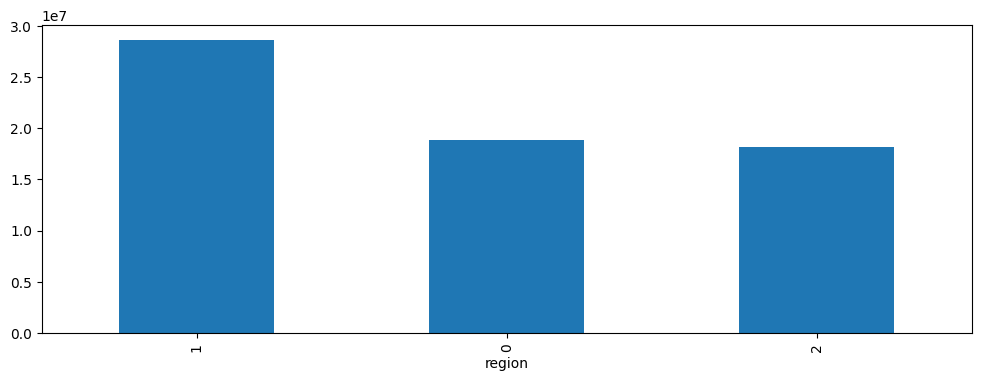

In [44]:
df.groupby(["region"])["Cantidad"].sum().sort_values(ascending = False).plot(kind = "bar", figsize = (12, 4))

### Ventas por tienda

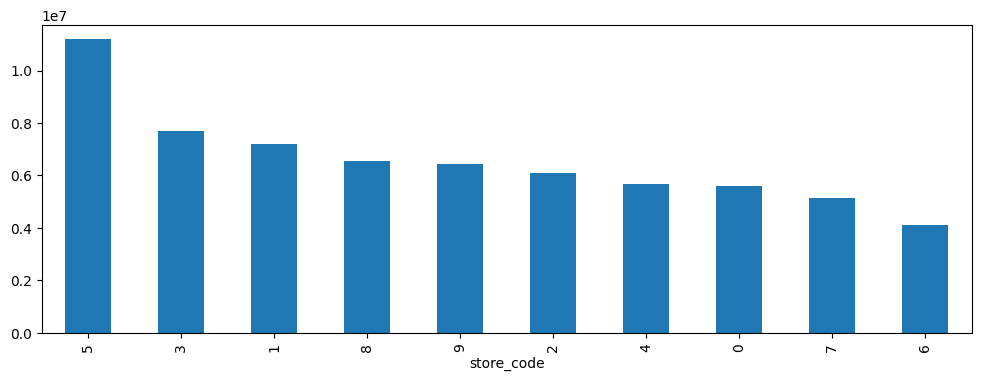

In [45]:
(
    df.
    groupby(["store_code"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Ventas por Categoria

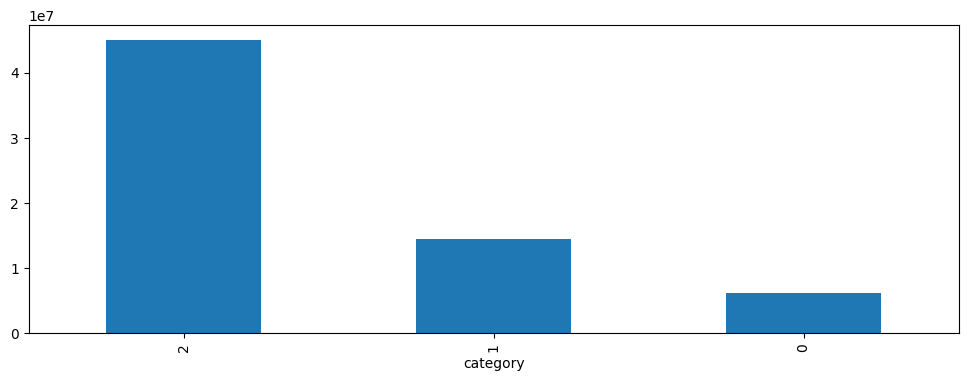

In [46]:
(
    df.
    groupby(["category"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Ventas por departamento

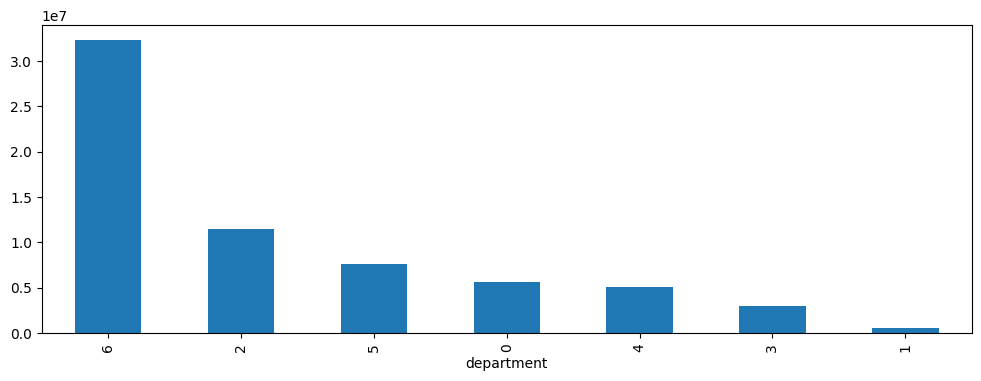

In [47]:
(
    df.
    groupby(["department"])
    ["Cantidad"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);